In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
import shutil
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
import pickle
import splitfolders
%matplotlib inline

In [10]:
df_train = pd.read_csv('book30-listing-train.csv',encoding = "ISO-8859-1")
df_test = pd.read_csv('book30-listing-test.csv',encoding = "ISO-8859-1")

In [11]:
df_test.head(5)

,044310073X,044310073X.jpg,http://ecx.images-amazon.com/images/I/41kSLEoswsL.jpg,"Oral and Maxillofacial Surgery: An Objective-Based Textbook, 2e",Unnamed: 4,16,Medical Books
0,1438005687,1438005687.jpg,http://ecx.images-amazon.com/images/I/510l0qhi...,"Barron's GRE, 21st Edition",Sharon Weiner Green M.A.,28,Test Preparation
1,60750715,0060750715.jpg,http://ecx.images-amazon.com/images/I/51p5aUY%...,George Balanchine: The Ballet Maker (Eminent L...,Robert Gottlieb,1,Biographies & Memoirs
2,1580237959,1580237959.jpg,http://ecx.images-amazon.com/images/I/51pum0eW...,"A Partner in Holiness: Deepening Mindfulness, ...",Rabbi Jonathan P. Slater DMin,21,Religion & Spirituality
3,135137829,0135137829.jpg,http://ecx.images-amazon.com/images/I/51PuTPPC...,Construction Scheduling: Principles and Practi...,Jay S. Newitt,0,Arts & Photography
4,312556411,0312556411.jpg,http://ecx.images-amazon.com/images/I/51uNnIlI...,Literature and Its Writers: A Compact Introduc...,Ann Charters,15,Literature & Fiction


In [12]:
columns = ['id', 'image', 'link', 'name', 'author', 'class', 'genre']
df_train.columns = columns
df_test.columns = columns

In [13]:
df_train.head()

,id,image,link,name,author,class,genre
0,1404803335,1404803335.jpg,http://ecx.images-amazon.com/images/I/51UJnL3T...,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books
1,1446276082,1446276082.jpg,http://ecx.images-amazon.com/images/I/51MGUKhk...,Energy Security (SAGE Library of International...,NaN,10,Engineering & Transportation
2,1491522666,1491522666.jpg,http://ecx.images-amazon.com/images/I/51qKvjsi...,An Amish Gathering: Life in Lancaster County,Beth Wiseman,9,Christian Books & Bibles
3,970096410,0970096410.jpg,http://ecx.images-amazon.com/images/I/51qoUENb...,City of Rocks Idaho: A Climber's Guide (Region...,Dave Bingham,26,Sports & Outdoors
4,8436808053,8436808053.jpg,http://ecx.images-amazon.com/images/I/41aDW5pz...,"Como vencer el insomnio. Tecnicas, reglas y co...",Choliz Montanes,11,"Health, Fitness & Dieting"


In [14]:
len(df_train.name)

51299

In [15]:
len(df_train.name.value_counts())

51000

In [16]:
df_train.drop_duplicates(subset='name',inplace=True)

In [17]:
len(df_train)

51000

In [18]:
len(df_test.name)

5699

In [19]:
len(df_test.name.value_counts())

5694

In [20]:
books = pd.DataFrame(df_train['name'])
author = pd.DataFrame(df_train['author'])
genre = pd.DataFrame(df_train['genre'])

In [21]:
df_train['author'] = df_train['author'].fillna('No Book')
df_train['name'] = df_train['name'].fillna('No Book')

In [22]:
print (len(books))
print (len(genre))
genre.head(2)
books[50000:50110]

51000
51000


,name
50281,Children and Marital Conflict: The Impact of F...
50282,Dead Until Dark (Sookie Stackhouse/True Blood...
50283,Forever Families: God's Gift of Adoption
50284,The Friendship Factor: How to Get Closer to th...
50285,"By Cecil H. Jensen, Jay D. Helsel: Interpretin..."
...,...
50387,Executive Power (The Mitch Rapp Series)
50388,"Love, Freedom, and Aloneness : A New Vision of..."
50389,The Lady from Zagreb (A Bernie Gunther Novel)
50390,Without Ritalin : A Natural Approach to ADD


In [23]:
genre['genre'].unique()

array(["Children's Books", 'Engineering & Transportation',
       'Christian Books & Bibles', 'Sports & Outdoors',
       'Health, Fitness & Dieting', 'Medical Books', 'Science & Math',
       'Travel', 'Business & Money', 'Cookbooks, Food & Wine',
       'Politics & Social Sciences', 'Crafts, Hobbies & Home',
       'Religion & Spirituality', 'Literature & Fiction',
       'Humor & Entertainment', 'Law', 'Computers & Technology',
       'Test Preparation', 'Biographies & Memoirs', 'Arts & Photography',
       'Parenting & Relationships', 'Romance', 'History',
       'Comics & Graphic Novels', 'Reference', 'Teen & Young Adult',
       'Self-Help', 'Calendars', 'Science Fiction & Fantasy',
       'Mystery, Thriller & Suspense'], dtype=object)

In [17]:
from sklearn.preprocessing import LabelEncoder

genero = ['genre']
for x in genero:
    le = LabelEncoder()
    le.fit(list(genre[x].values))
    genre[x] = le.transform(list(genre[x]))

In [18]:
genre['genre'].unique()

array([ 4, 10,  5, 26, 11, 16, 23, 29,  2,  8, 19,  9, 21, 15, 13, 14,  7,
       28,  1,  0, 18, 22, 12,  6, 20, 27, 25,  3, 24, 17])

In [19]:
le.inverse_transform([0])[0]

'Arts & Photography'

Baseline model:

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, max_features=70000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w+', use_idf=True, 
                            smooth_idf=True, sublinear_tf=True, stop_words = 'english')
vectors = vectorizer.fit_transform(df_train['name'])
vectors.shape

(51000, 17624)

In [21]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(vectors, genre['genre'], test_size=0.1,random_state=73)

In [23]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(45900, 17624)
(45900,)
(5100, 17624)
(5100,)


In [24]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver= 'sag',max_iter=200,random_state=73)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5635710695010574
0.5613725490196079


In [25]:

pickle.dump(clf, open('modelLR.pkl', 'wb'))

In [26]:
len(y_test.unique())

30

In [27]:
len(pred)

5100

In [28]:
pred

array([14, 11, 28, ...,  1, 15, 25])

In [29]:
k=3
probs = clf.predict_proba(X_test)
# Sort desc and only extract the top-n
top_n = np.argsort(probs)[:,:-k-1:-1]

In [30]:
from sklearn.metrics import top_k_accuracy_score

print(top_k_accuracy_score(y_test, probs, k=3, normalize=True))

0.7568627450980392


In [31]:
top_n

array([[14,  2, 28],
       [11, 18, 25],
       [28, 20, 19],
       ...,
       [ 1,  7, 12],
       [15, 19,  1],
       [25, 18, 21]], dtype=int64)

MLP:

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train_scal =scaler.transform(X_train)
X_test_scal =scaler.transform(X_test)

mlp = MLPClassifier(max_iter=500,
                   activation='relu',
                   hidden_layer_sizes = (150, 150, 150),
                   random_state=73,
                   learning_rate_init=0.01)
mlp.fit(X_train_scal, y_train)
print(mlp.score(X_train_scal, y_train))
print(mlp.score(X_test_scal, y_test))

0.8099346405228758
0.4131372549019608


In [33]:
predp = mlp.predict_proba(X_test_scal)
print(top_k_accuracy_score(y_test, predp, k=3, normalize=True))

0.5237254901960784


Random forest:

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

print(rnd_clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred_rf))


0.39372549019607844
0.38


In [63]:
pred = rnd_clf.predict_proba(X_test)
print(top_k_accuracy_score(y_test, pred, k=3, normalize=True))

0.5405882352941176


Usando el nombre del escritor:

In [36]:
df_train['everything'] = pd.DataFrame(df_train['name'] + ' ' + df_train['author'])
print (df_train['everything'].head(5))

0    Magnets: Pulling Together, Pushing Apart (Amaz...
1    Energy Security (SAGE Library of International...
2    An Amish Gathering: Life in Lancaster County B...
3    City of Rocks Idaho: A Climber's Guide (Region...
4    Como vencer el insomnio. Tecnicas, reglas y co...
Name: everything, dtype: object


In [37]:
vectorizer2 = TfidfVectorizer(min_df=2, max_features=70000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w+', use_idf=True, 
                            smooth_idf=True, sublinear_tf=True, stop_words = 'english')
vectors2 = vectorizer2.fit_transform(df_train['everything'])
vectors2.shape

(51000, 24910)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(vectors2, genre['genre'], test_size=0.1,random_state=73)

In [39]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver= 'sag',max_iter=200,random_state=73)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5821420109259273
0.5805882352941176


In [60]:
clf.score(X_train,y_train)

0.7681481481481481

In [40]:
probs = clf.predict_proba(X_test)
print(top_k_accuracy_score(y_test, probs, k=3, normalize=True))
print(top_k_accuracy_score(y_test, probs, k=5, normalize=True))

0.7725490196078432
0.8398039215686275


In [41]:
pickle.dump(clf, open('bestmodelLR.pkl', 'wb'))

XGBoost

In [42]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test)

In [43]:
params = {
    'objective':'multi:softmax',
    'eval_metric':'mlogloss',
    'eta':0.025,
    'max_depth':10,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':5,
    'num_class': 30
    
}

In [44]:
bst = xgb.cv(params, dtrain, num_boost_round=100,
early_stopping_rounds=40, nfold=5, verbose_eval=10)

[0]	train-mlogloss:3.36904+0.00039	test-mlogloss:3.37083+0.00047
[10]	train-mlogloss:3.13423+0.00546	test-mlogloss:3.15172+0.00726
[20]	train-mlogloss:2.99232+0.00216	test-mlogloss:3.02302+0.00488
[30]	train-mlogloss:2.88414+0.00155	test-mlogloss:2.92737+0.00436
[40]	train-mlogloss:2.79528+0.00223	test-mlogloss:2.85066+0.00347
[50]	train-mlogloss:2.71942+0.00216	test-mlogloss:2.78591+0.00322
[60]	train-mlogloss:2.65263+0.00283	test-mlogloss:2.72961+0.00394
[70]	train-mlogloss:2.59455+0.00363	test-mlogloss:2.68095+0.00291
[80]	train-mlogloss:2.54331+0.00366	test-mlogloss:2.63820+0.00293
[90]	train-mlogloss:2.49850+0.00391	test-mlogloss:2.60133+0.00261
[99]	train-mlogloss:2.46214+0.00344	test-mlogloss:2.57163+0.00193


In [45]:
bst

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,3.369040,0.000391,3.370828,0.000472
1,3.334157,0.002244,3.337869,0.001848
2,3.304428,0.001665,3.309839,0.002635
3,3.277161,0.002597,3.284389,0.004142
4,3.251567,0.002385,3.260367,0.004091
...,...,...,...,...
95,2.477823,0.003750,2.584441,0.002236
96,2.473791,0.003644,2.581121,0.002101
97,2.469836,0.003546,2.577890,0.001998
98,2.465967,0.003494,2.574776,0.001973


In [46]:
bst_train = xgb.train(params, dtrain, num_boost_round=100) 

In [65]:
p_test = bst_train.predict(dtest)
p_train = bst_train.predict(dtrain)

In [66]:
print(metrics.accuracy_score(y_train, p_train)) 

0.4362962962962963


In [48]:
print (metrics.f1_score(y_test, p_test, average='macro'))
print (metrics.accuracy_score(y_test, p_test)) 

0.397133701420185
0.39137254901960783


In [49]:
file = open('bestmodelLR.pkl','rb')
clf = pickle.load(file)


In [50]:
text = ['Fifty Shades of Grey']
#text = list(text)
s = (vectorizer2.transform(text))
#s = vectorizer.fit_transform(df)
print (s.shape)
p = (clf.predict_proba(s))
q = (clf.predict(s))

(1, 24910)


In [51]:
def predict(title):
    text = title
    s = (vectorizer2.transform(text))
    p = (clf.predict(s))
    print(le.inverse_transform(p)[0])

In [52]:
def predict_top_k(title,k):
    text = title
    s = (vectorizer2.transform(text))
    p = (clf.predict_proba(s))
    a=p[0]
    ind =(-a).argsort()[:k]
    print(le.inverse_transform(ind))

In [53]:
title = ['The Hobbit']
predict(title)

Science Fiction & Fantasy


In [54]:
title = ['The Shadow Of The Wind Carlos Ruiz Zafon']
predict(title)

Mystery, Thriller & Suspense


In [55]:
title = ["In Valeria's shoes Elisabet Benavent"]
predict(title)

Children's Books


In [56]:
predict_top_k(title,3)

["Children's Books" 'Teen & Young Adult' 'Parenting & Relationships']


In [ ]:
print(le.inverse_transform(ind))

['Romance' 'Teen & Young Adult' 'Arts & Photography']


In [ ]:
pred = clf.predict(X_test)
print (metrics.f1_score(y_test, pred, average='macro'))
print (metrics.accuracy_score(y_test, pred))

0.5821420109259273
0.5805882352941176


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
result = confusion_matrix(y_test, pred)
print(result)

[[ 87  10   2   1   5   2   4   7   0  16   9   1   9   6   2   4   0   0
    2   4   3   0   4   2   1   2   0   5   1   3]
 [  5  68   2   0   5   6   2   2   0   0   0   1  16   4   3   3   2   4
    6   3   3   4   3   1   3   6  10   9   0   5]
 [  2   2 101   0   2   3   2  10   1   0   1   0   3   0   3   0   1   0
    2   6   2   2   0   1   0   8   0   2   1   1]
 [  3   0   0 164   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   1   0   0   0   0   0   1]
 [  4   8   3   0  75   5   2   1   0   3   3   0   4   5   0   3   0   2
    3   2   3   3   5   6   3   0   5  12   2   2]
 [  1   9   2   0   8 108   1   0   2   2   1   1   5   0   1   2   1   5
    4   2   3   8   8   4   6   6   1   2   0   1]
 [  6   5   0   0   9   1 128   0   1   1   0   0   5   3   0  10   0   2
    1   0   1   0   8   2   8   1   1   3   0   0]
 [  4   1   3   0   1   0   0 112   0   1   3   0   0   1   2   1   1   1
    0   0   1   2   0   7   0   0   3   2   2   2]


<AxesSubplot: >

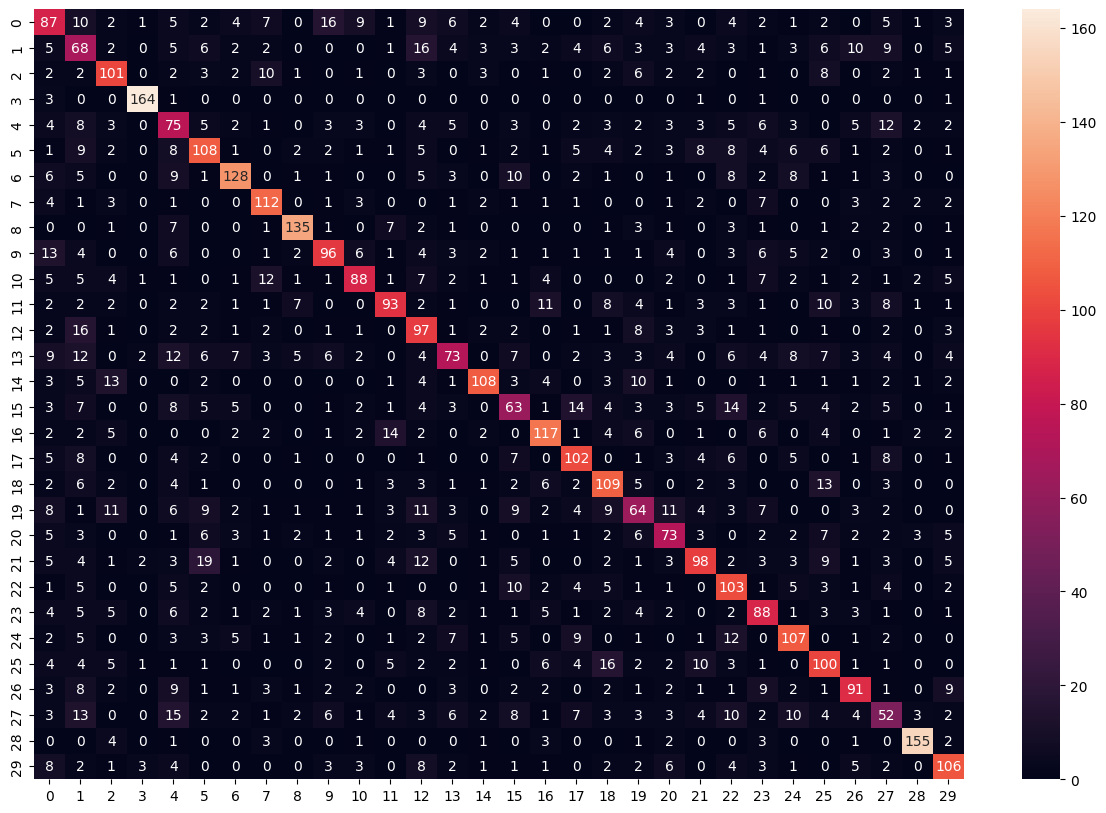

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(result,annot=True, fmt='g')